# Image Understanding with RAG using OpenAI's Vision & Responses APIs

Welcome! This notebook demonstrates how to build a Retrieval-Augmented Generation (RAG) system using OpenAI’s Vision and Responses APIs. It focuses on multimodal data, combining image and text inputs to analyze customer experiences. The system leverages GPT-5 and integrates image understanding with file search to provide context-aware responses.

Multimodal datasets are increasingly common, particularly in domains like healthcare, where records often contain both visual data (e.g. radiology scans) and accompanying text (e.g. clinical notes). Real-world datasets also tend to be noisy, with incomplete or missing information, making it critical to analyze multiple modalities in tandem.

This guide focuses on a customer service use case: evaluating customer feedback that may include photos, and written reviews. You’ll learn how to synthetically generate both image and text inputs, use file search for context retrieval, and apply the Evals API to assess how incorporating image understanding impacts overall performance.

---

## Overview

---

## Table of Contents

1. [Setup & Dependencies](#setup-and-dependencies)
2. [Example Generations](#example-generations)
3. [Data Processing](#data-processing)
   - Load synthetic datasets
   - Merge data
4. [Populating Vector Store](#populating-vector-store)
   - Upload data for file search
   - Set up attribute filters
5. [Retrieval and Filtering](#retrieval-and-filtering)
   - Test retrieval performance
   - Apply attribute-based filters
6. [Evaluation and Analysis](#evaluation-and-analysis)
   - Compare predictions to ground truth
   - Analyze performance metrics

## Setup and Dependencies

In [ ]:
%pip install openai evals pandas numpy matplotlib tqdm ipython --upgrade --quiet

In [ ]:
import base64
from io import BytesIO
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from openai import OpenAI
from IPython.display import display, Image
from tqdm.notebook import tqdm

cache_dir = Path('.local_cache')
cache_dir.mkdir(parents=True, exist_ok=True)

client = OpenAI()

## Example Generations

Generating high-quality training and evaluation data for machine learning tasks can be costly and time-consuming. Synthetic data offers a practical and scalable alternative. In this notebook, the OpenAI Image API is used to generate synthetic images, while the Responses API is employed to create synthetic text, enabling efficient prototyping and experimentation across multimodal tasks.

In [ ]:

prompt = ("Gourmet pasta neatly plated with garnish and sides on a white ceramic plate, "
          "photographed from above on a restaurant table. Soft shadows and vibrant colors.")
cache_path = f".local_cache/{hash(prompt)}.png"

if not os.path.exists(cache_path):
    response = client.images.generate(
        model="gpt-image-1",
        prompt=prompt,
        size="1024x1024"
    )
    
    with open(cache_path, "wb") as f:
        f.write(base64.b64decode(response.data[0].b64_json))
    print(f"Generated and cached: {cache_path}")

else:
    print(f"Loading from cache: {cache_path}")

display(Image(filename=cache_path))

In [4]:
def generate_food_delivery_review(sentiment: str = 'positive') -> str:
    """
    Generate a synthetic food delivery review with the specified sentiment.
    
    Args:
        sentiment: An adjective such as 'positive' or 'negative'.
    
    Returns:
        Generated review text
    """
    prompt = "Write a very concise, realistic customer review for a recent food delivery."
    prompt += f" The review should reflect a {sentiment} experience."
    
    response = client.responses.create(
        model="gpt-5",
        reasoning={"effort": "minimal"},
        input=[{"role": "user", "content": prompt}]
    )
    return response.output_text


review = generate_food_delivery_review()
print(review)

Order arrived 10 minutes early, food was hot and packaged securely. Tacos were fresh, well-seasoned, and the salsa tasted homemade. Driver was friendly, followed instructions, and left it at the door. Will definitely order again.


## Data Processing

In this example, we’ll work with a pre-generated synthetic dataset of customer feedback that includes short text snippets, images from customer reviews, and occasionally combined multimodal entries. You can also generate your own synthetic dataset using the examples provided above to tailor the data to your specific use case.

In [ ]:
# Download the dataset
! mkdir -p .local_cache/images
! wget https://raw.githubusercontent.com/robtinn/image_understanding_rag_dataset/main/data/df.csv -O .local_cache/df.csv


! wget https://raw.githubusercontent.com/robtinn/image_understanding_rag_dataset/main/data/images/1.png -O .local_cache/images/1.png
! wget https://raw.githubusercontent.com/robtinn/image_understanding_rag_dataset/main/data/images/2.png -O .local_cache/images/2.png
! wget https://raw.githubusercontent.com/robtinn/image_understanding_rag_dataset/main/data/images/3.png -O .local_cache/images/3.png
! wget https://raw.githubusercontent.com/robtinn/image_understanding_rag_dataset/main/data/images/4.png -O .local_cache/images/4.png
! wget https://raw.githubusercontent.com/robtinn/image_understanding_rag_dataset/main/data/images/5.png -O .local_cache/images/5.png
! wget https://raw.githubusercontent.com/robtinn/image_understanding_rag_dataset/main/data/images/6.png -O .local_cache/images/6.png
! wget https://raw.githubusercontent.com/robtinn/image_understanding_rag_dataset/main/data/images/7.png -O .local_cache/images/7.png

In [6]:
def encode_image(image_path: str) -> str:
    """Encode image file to base64 string."""
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")


def analyze_image_sentiment(image_path: str) -> str:
    """Analyze food delivery image and return sentiment analysis."""
    base64_image = encode_image(image_path)
    response = client.responses.create(
        model="gpt-5",
        reasoning={"effort": "minimal"},
        input=[{
            "role": "user",
            "content": [
                {
                    "type": "input_text",
                    "text": "Analyze this food delivery image. Respond with a brief description and sentiment (positive/negative) in one line."
                },
                {
                    "type": "input_image",
                    "image_url": f"data:image/jpeg;base64,{base64_image}",
                },
            ],
        }],
    )
    return response.output_text.strip()

In [ ]:
df = pd.read_csv(".local_cache/df.csv")
cache_dir = Path(".local_cache")

for idx, row in df[~df['image_path'].isna()].iterrows():
    image_path = cache_dir / 'images' / row['image_path']
    sentiment = analyze_image_sentiment(str(image_path))
    df.at[idx, 'full_sentiment'] = f"{row['text']} {sentiment}" if pd.notna(row['text']) else sentiment
    print(f"Processed {row['image_path']}")

df['full_sentiment'] = df['full_sentiment'].fillna(df['text'])

output_path = cache_dir / "df_full_sentiment.csv"
df.to_csv(output_path, index=False)
print(f"\nSaved results to {output_path}")

In [8]:
pd.set_option('display.max_colwidth', 100)  # Increase from default (50) to view full sentiment
display(df.head())

,id,month,text,image_path,label,full_sentiment
0,1,june,"Absolutely delicious! The sushi was fresh, beautifully packed, and arrived right on time. Will d...",NaN,positive,"Absolutely delicious! The sushi was fresh, beautifully packed, and arrived right on time. Will d..."
1,2,july,Half my order was missing and the burger looked thrown together. Not worth the money.,NaN,negative,Half my order was missing and the burger looked thrown together. Not worth the money.
2,3,july,Packaging was leaking sauce everywhere. Presentation was a mess. Tasted like leftovers.,NaN,negative,Packaging was leaking sauce everywhere. Presentation was a mess. Tasted like leftovers.
3,4,july,"Burger was hot, fries were still crispy, and the milkshake wasn’t melted at all. Fantastic deliv...",3.png,positive,"Burger was hot, fries were still crispy, and the milkshake wasn’t melted at all. Fantastic deliv..."
4,5,june,Received the wrong items. I ordered vegetarian and got meat. Totally unacceptable.,NaN,negative,Received the wrong items. I ordered vegetarian and got meat. Totally unacceptable.


## Populating Vector Store

This example uses OpenAI's built-in vector store and file search capabilities to build a RAG system that can analyse customer experiences from their feedback, which can be both visual and text-based. We create two vector stores for comparisons, one with image understanding and one without.

In [ ]:
text_vector_store = client.vector_stores.create(
    name="food_delivery_reviews_text",
    metadata={
        "purpose": "text_understanding",
        "created_by": "notebook",
        "version": "1.0"
    }
)
text_vector_store_id = text_vector_store.id

text_image_vector_store = client.vector_stores.create(
    name="food_delivery_reviews_text_image",
    metadata={
        "purpose": "text_image_understanding",
        "created_by": "notebook",
        "version": "1.0"
    }
)
text_image_vector_store_id = text_image_vector_store.id

print("Vector Store IDs:")
print(f"  Text:       {text_vector_store_id}")
print(f"  Text+Image: {text_image_vector_store_id}")

In [10]:
# upload files to vector database and set metadata

def upload_files_to_vector_store(vector_store_id, df, column_name="full_sentiment"):
    file_ids = []
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Uploading context files"):
        if pd.isna(row[column_name]):
            file_stream = BytesIO('No information available.'.encode('utf-8'))
        else:
            file_stream = BytesIO(row[column_name].encode('utf-8'))
        file_stream.name = f"context_{row.get('id', i)}_{row.get('month', '')}.txt"
        
        file = client.vector_stores.files.upload(
            vector_store_id=vector_store_id,
            file=file_stream
        )
        file_ids.append(file.id)

    for i, row in tqdm(df.iterrows(), total=len(df), desc="Updating file attributes"):
        client.vector_stores.files.update(
            vector_store_id=vector_store_id,
            file_id=file_ids[i],
            attributes={"month": row["month"]}
        )

In [ ]:
upload_files_to_vector_store(text_image_vector_store_id, df)
upload_files_to_vector_store(text_vector_store_id, df, column_name="text")

# Retrieval and Filtering

We can analyse our dataset with natural language queries with the help of File Search. For the text-only dataset, we see that information is missing that could inform our analysis.

The only positive review for spaghetti in July has visual feedback and we can see the RAG system with only text based context available is uncertain about positive details. However with image context provided the second RAG system is able to provide a more accurate response.


In [12]:
# Query the vector store for spaghetti reviews in July
query = "Where there any comments about the 'spaghetti'?"
print(f"🔍 Query: {query}\n")

# Execute the search with filtering
response = client.responses.create(
    model="gpt-5",
    input=query,
    tools=[{
        "type": "file_search",
        "vector_store_ids": [text_vector_store_id],
        "filters": {
            "type": "eq",
            "key": "month",
            "value": "july"
        }
    }]
)

# Display the results
print("📝 Response:")
print("-" * 40)
print(response.output_text)

🔍 Query: Where there any comments about the 'spaghetti'?

📝 Response:
----------------------------------------
I couldn’t find any comments that explicitly mention “spaghetti.” The closest related note says “Pasta was overcooked” in context_9_july.txt . If you have a specific date or file in mind, I can check that directly.


In [13]:
query = "Where there any comments about the 'spaghetti'?"
print(f"🔍 Query: {query}\n")

response = client.responses.create(
    model="gpt-5",
    input=query,
    tools=[{
        "type": "file_search",
        "vector_store_ids": [text_image_vector_store_id],
        "filters": {
            "type": "eq",
            "key": "month",
            "value": "july"
        }
    }]
)

print("📝 Response:")
print("-" * 40)
print(response.output_text)

🔍 Query: Where there any comments about the 'spaghetti'?

📝 Response:
----------------------------------------
Yes. There’s a positive note describing “a neatly plated spaghetti in tomato sauce with parsley, served alongside arugula, garlic bread, and grated cheese.” 


We can confirm if this is correct by checking the retrieved images.

In [ ]:
IMAGE_ID_MAPPING = {
    f"context_{row['id']}_{row['month']}.txt": row["image_path"]
    for _, row in df[~df['image_path'].isna()].iterrows()
}

def display_retrieved_images(
    response,
    cache_dir: str = ".local_cache"
):
    """
    Display images from the retrieved search results.
    
    Args:
        response: The response object from the search query
        cache_dir: Directory where images are stored
        
    Returns:
        Dict mapping filenames to image paths for the displayed images
    """
    # Get the annotations from the response
    try:
        annotations = response.output[3].content[0].annotations
        retrieved_files = {result.filename for result in annotations}
    except (AttributeError, IndexError):
        print("No search results found in the response.")
        return {}


    # Display matching images
    displayed_images = {}
    for file in retrieved_files:
        if file in IMAGE_ID_MAPPING and IMAGE_ID_MAPPING[file]:
            image_path = Path(cache_dir) / 'images' / IMAGE_ID_MAPPING[file]
            print(f"Displaying image for {file}:")
            display(Image(str(image_path)))
            displayed_images[file] = str(image_path)
    
    return displayed_images

displayed = display_retrieved_images(response)
print(f"Displayed {len(displayed)} images")

Likewise we can test this for negative reviews in June concerning any burnt pizza.

In [15]:
query = "Were there any negative reviews for pizza, and if so, was the pizza burnt?"
print(f"🔍 Query: {query}\n")

response = client.responses.create(
    model="gpt-5",
    input=query,
    tools=[{
        "type": "file_search",
        "vector_store_ids": [text_image_vector_store_id],
        "filters": {
            "type": "eq",
            "key": "month",
            "value": "june"
        }
    }]
)

print("📝 Response:")
print("-" * 40)
print(response.output_text)

🔍 Query: Were there any negative reviews for pizza, and if so, was the pizza burnt?

📝 Response:
----------------------------------------
Yes. One review explicitly describes a “burnt pepperoni pizza with charred crust and grease stains in the box” and is marked as negative sentiment .


We can confirm if this is correct by checking the retrieved images.

In [ ]:
displayed = display_retrieved_images(response)
print(f"Displayed {len(displayed)} images")

## Evaluation and Analysis

As our dataset likely evolves over time and we want to evaluate new models, we can use the OpenAI Evaluation API to evaluate the performance of our system for sentiment analysis. In this simple example, using the string_check criteria we checked if the output was one of the three possible values: positive, negative, or unclear.

In [17]:
def prepare_evaluation_data(
    df: pd.DataFrame,
    text_col: str = "full_sentiment",
    label_col: str = "label"
) -> list:
    """
    Prepare evaluation data items from a DataFrame.
    
    Args:
        df: Input pandas DataFrame.
        text_col: Column containing the input text.
        label_col: Column containing the ground truth label.
    
    Returns:
        List of dicts formatted for evaluation.
    """
    return [
        {"item": {"input": str(row[text_col]), "ground_truth": row[label_col]}}
        for _, row in df.iterrows()
    ]

def create_eval_run(evaluation_data: list, eval_id: str) -> str:
    """
    Create and launch an evaluation run.
    
    Args:
        evaluation_data: List of evaluation items.
        eval_id: The evaluation object ID.
    
    Returns:
        The run ID as a string.
    """
    eval_config = {
        "type": "completions",
        "model": "gpt-5",
        "input_messages": {
            "type": "template",
            "template": [
                {
                    "type": "message",
                    "role": "user",
                    "content": {
                        "type": "input_text",
                        "text": (
                            "Classify the sentiment of this food delivery review: {{ item.input }}. "
                            "Categorize the request into one of \"positive\", \"negative\" or \"unclear\". "
                            "Respond with only one of those words."
                        )
                    }
                }
            ]
        },
        "source": {
            "type": "file_content",
            "content": evaluation_data
        }
    }

    run = client.evals.runs.create(
        eval_id=eval_id,
        data_source=eval_config
    )
    print("✅ Evaluation run created successfully")
    print(f"Run ID: {run.id}")
    return run.id

In [ ]:
eval_obj = client.evals.create(
    name="food-categorization-eval",
    data_source_config={
        "type": "custom",
        "item_schema": {
            "type": "object",
            "properties": {
                "input": {"type": "string"},
                "ground_truth": {"type": "string"}
            },
            "required": ["input", "ground_truth"]
        },
        "include_sample_schema": True
    },
    testing_criteria=[
        {
            "type": "string_check",
            "name": "Match output to human label",
            "input": "{{sample.output_text}}",
            "reference": "{{item.ground_truth}}",
            "operation": "eq"
        }
    ]
)
eval_id = eval_obj.id
eval_id

In [ ]:
# create evaluation runs

evaluation_data = prepare_evaluation_data(df, text_col="text")
text_only_run_id = create_eval_run(evaluation_data, eval_id)

evaluation_data = prepare_evaluation_data(df)
text_image_run_id = create_eval_run(evaluation_data, eval_id)

# retrieve both run urls

text_only_run = client.evals.runs.retrieve(eval_id=eval_id, run_id=text_only_run_id)
print(text_only_run.to_dict()['report_url'])

text_image_run = client.evals.runs.retrieve(eval_id=eval_obj.id, run_id=text_image_run_id)
print(text_image_run.to_dict()['report_url'])

In [24]:
# you may need to wait a few seconds before running this cell for the eval runs to finish up

text_only_run_output_items = client.evals.runs.output_items.list(eval_id=eval_id, run_id=text_only_run_id)
text_image_run_output_items = client.evals.runs.output_items.list(eval_id=eval_id, run_id=text_image_run_id)

We can retrieve the results of these evaluation runs and perform some local analysis. In this case, we will compare the performance of the text-only and text+image runs and evaluate how increasing the number of total tokens (through the addition of image context) affects the accuracy of the model. We can also do some basic error analysis by analysing the model input of the failed examples.

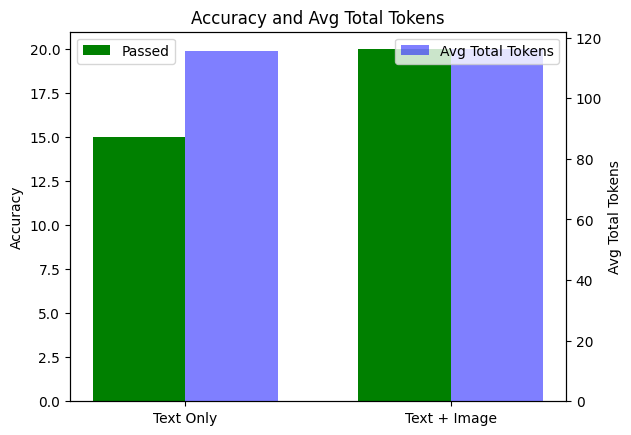

In [25]:
# Calculate passed and total for text_only_run
text_only_data = text_only_run_output_items.to_dict()['data']
text_only_passed = sum(1 for output_item in text_only_data if output_item['results'][0]['passed'])
text_only_total = len(text_only_data)

# Calculate passed and total for text_image_run
text_image_data = text_image_run_output_items.to_dict()['data']
text_image_passed = sum(1 for output_item in text_image_data if output_item['results'][0]['passed'])
text_image_total = len(text_image_data)

# Calculate average total_tokens for each run
def avg_total_tokens(data):
    tokens = [item['sample']['usage']['total_tokens'] for item in data if 'usage' in item['sample']]
    return sum(tokens) / len(tokens) if tokens else 0

text_only_avg_tokens = avg_total_tokens(text_only_data)
text_image_avg_tokens = avg_total_tokens(text_image_data)

# Plotting
labels = ['Text Only', 'Text + Image']
passed = [text_only_passed, text_image_passed]
avg_tokens = [text_only_avg_tokens, text_image_avg_tokens]

x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots()

# Bar for passed only
bars1 = ax1.bar(x - width/2, passed, width, label='Passed', color='green')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_title('Accuracy and Avg Total Tokens')
ax1.legend(loc='upper left')

# Second y-axis for avg total tokens
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, avg_tokens, width, label='Avg Total Tokens', color='blue', alpha=0.5)
ax2.set_ylabel('Avg Total Tokens')
ax2.legend(loc='upper right')

plt.show()

In [27]:
failed_samples = [
    {
        "Input": sample['sample']['input'],
        "Model Output": sample['sample']['output']
    }
    for sample in text_only_run_output_items.to_dict()['data']
    if not sample['results'][0]['passed']
]

pd.set_option('display.max_colwidth', 150)  # Adjust as needed

failed_df = pd.DataFrame(failed_samples)
display(failed_df.style.set_properties(**{'text-align': 'left'}))

,Input,Model Output
0,"[{'content': 'Classify the sentiment of this food delivery review: The food came looking like this... Categorize the request into one of ""positive"", ""negative"" or ""unclear"". Respond with only one of those words.', 'role': 'user'}]","[{'content': 'negative', 'role': 'assistant'}]"
1,"[{'content': 'Classify the sentiment of this food delivery review: nan. Categorize the request into one of ""positive"", ""negative"" or ""unclear"". Respond with only one of those words.', 'role': 'user'}]","[{'content': 'unclear', 'role': 'assistant'}]"
2,"[{'content': 'Classify the sentiment of this food delivery review: nan. Categorize the request into one of ""positive"", ""negative"" or ""unclear"". Respond with only one of those words.', 'role': 'user'}]","[{'content': 'unclear', 'role': 'assistant'}]"
3,"[{'content': 'Classify the sentiment of this food delivery review: nan. Categorize the request into one of ""positive"", ""negative"" or ""unclear"". Respond with only one of those words.', 'role': 'user'}]","[{'content': 'unclear', 'role': 'assistant'}]"
4,"[{'content': 'Classify the sentiment of this food delivery review: Wow look at this pizza!. Categorize the request into one of ""positive"", ""negative"" or ""unclear"". Respond with only one of those words.', 'role': 'user'}]","[{'content': 'positive', 'role': 'assistant'}]"


Finally, let's clean up some of the resources we created.

In [ ]:
# delete vector stores
deleted_vector_store = client.vector_stores.delete(
  vector_store_id=text_vector_store_id
)
print(deleted_vector_store)

deleted_vector_store = client.vector_stores.delete(
  vector_store_id=text_image_vector_store_id
)
print(deleted_vector_store)